# Introduction

This notebook is a step-by-step walkthrough to:
1. Extract kinetic parameters from a set of growthrate-data (e.g. as obtained from GrowthCurveProcessing.R, but any set of growth rate data could be used here)
2. Use the obtained kinetic parameters in the developed dynamic mass-balance model for growth of and production by Clostridium kluyveri.

Both goals can be adapted for other purposes and applications. The applied mathematical equations and stoichiometry can be adapted to fit the process under investigation, while the the method and steps in the approach remain the same.

To run this code, the pyIDEAS package (Van Daele, 2015), needs to be installed. This code is publicly available at github.com/FILLINNAMEHERE

# Preamble

In [1]:
import pandas as pd
import numpy as np
import collections

In [2]:
import matplotlib.pyplot as plt

In [3]:
from pyideas import (Model,AlgebraicModel, Measurements, ParameterOptimisation,
                      CalibratedConfidence, ModPar)

In [4]:
%matplotlib inline

# Read and Clean Data

In [5]:
#Read total dataset - will be used in model calibration

conc_profile = pd.read_csv('ProcessedData_Example.csv')[[r'Experiment','EtOH', 'AA','BA', 'HA', 'mu']]
Data_All = conc_profile.set_index([r'Experiment', 'EtOH', 'AA','BA', 'HA'])

#Read dataset per substrate - will be used in model selection step

##AA
Data_AA = pd.read_csv('ProcessedData_Example.csv')[[r'Experiment','AA', 'mu']]
Data_AA_A = Data_AA[Data_AA.Experiment==1]
Data_AA_B = Data_AA[Data_AA.Experiment==2]
Data_AA = pd.concat([Data_AA_A, Data_AA_B])
Data_AA.columns=['Experiment','S', 'mu']
Data_AA = Data_AA.set_index([r'Experiment', 'S'])
Data_AA = Data_AA.sort_index(level='S')

##BA
Data_BA = pd.read_csv('ProcessedData_Example.csv')[[r'Experiment','AA','BA', 'mu']]
Data_BA_E = Data_BA[Data_BA.Experiment==5]
Data_BA_F = Data_BA[Data_BA.Experiment==6]
Data_BA = pd.concat([Data_BA_E, Data_BA_F])
Data_BA.columns=['Experiment','AA','S', 'mu']
Data_BA = Data_BA.set_index([r'Experiment', 'AA','S'])
Data_BA = Data_BA.sort_index(level=['AA','S'])

##HA
Data_HA = pd.read_csv('ProcessedData_Example.csv')[[r'Experiment','HA', 'mu']]
Data_HA = Data_HA[Data_HA.Experiment==7]
Data_HA.columns=['Experiment','S', 'mu']
Data_HA = Data_HA.set_index([r'Experiment', 'S'])
Data_HA = Data_HA.sort_index(level='S')

In [6]:
type(Data_AA)

pandas.core.frame.DataFrame

# Model Selection

## Acetic Acid

### Definition of models

In [7]:
#Define kinetic AA-models for model selection
Syst_AA_Monod = {'mu': ('mu_max*(S/(K_S + S))')} # Monod, 1949
Syst_AA_Haldane= {'mu': ('mu_max*(S/(K_S+S+S^2/Ki))')} # Sivakumar et al., 1994
Syst_AA_Mon_ToxLim= {'mu': ('mu_max*(S/(K_S + S))*(1-1/(1+exp(-(S-Ki))))')} #Proposed

#Define initial parameter estimations for calibration of model selections
parameters_AA_Mon = {'K_S': 3.5, #Cavalcante et al. (2016)
                          'mu_max': max(Data_All.mu)} #Maximum of all obtained growth rates in experiments A and B
parameters_AA_Hal = {'mu_max': max(Data_All.mu),
                          'K_S': 3.5,
                          'Ki': 330.} #Arbitrarily chosen inhibition concentration
parameters_AA_Mon_ToxLim = {'mu_max': max(Data_All.mu),
                         'K_S': 3.5,
                         'Ki': 330.}

### Monod

In [8]:
AA_Monod = AlgebraicModel('3D', Syst_AA_Monod, parameters_AA_Mon, ['S'])

AA_Monod_data = Measurements(Data_AA)

AA_Monod_data.add_measured_errors({'mu': 0.04}, method='absolute')
AA_Monod_optim = ParameterOptimisation(AA_Monod, AA_Monod_data,
                                optim_par=['mu_max', 'K_S'])

In [9]:
AA_Monod_optim.local_optimize(method='Nelder-Mead',
                       options={'xatol': 1e-10, 'fatol': 1e-10})

pyideas\optimisation.py:223: OptimizeWarning: Unknown solver options: fatol, xatol
  method=method, **kwargs)


 final_simplex: (array([[ 0.17209758, -2.06773423],
       [ 0.17209758, -2.06767888],
       [ 0.17209691, -2.06773905]]), array([ 566.58318551,  566.58318551,  566.58318551]))
           fun: 566.58318550993272
       message: 'Optimization terminated successfully.'
          nfev: 127
           nit: 66
        status: 0
       success: True
             x: array([ 0.17209758, -2.06773423])

The value 'fun' is the residuals after fitting of the model to the data. For the conventional Monod model, the residuals value is 566.6.

In [10]:
AA_Monod_conf = CalibratedConfidence(AA_Monod_optim)
AA_Monod_conf.get_parameter_confidence()

,value,lower,upper,delta,percent,t_value,t_reference,significant
mu_max,0.172098,0.162839,0.181357,0.009259,5.380117,36.875989,1.983972,1.0
K_S,-2.067679,-3.504469,-0.630889,1.436790,69.488070,-2.855125,1.983972,0.0


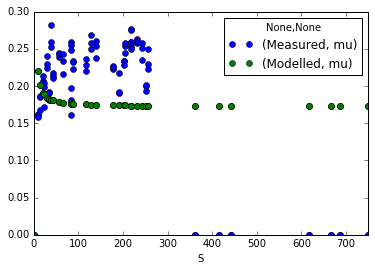

In [11]:
AA_Monod_optim.modmeas.plot(style='o')

### Haldane

In [12]:
AA_Haldane = AlgebraicModel('3D', Syst_AA_Haldane, parameters_AA_Hal, ['S'])
AA_Haldane_data = Measurements(Data_AA)
AA_Haldane_data.add_measured_errors({'mu': 0.04}, method='absolute')
AA_Haldane_optim = ParameterOptimisation(AA_Haldane, AA_Haldane_data,
                                optim_par=['mu_max', 'K_S','Ki'])

In [13]:
AA_Haldane_optim.local_optimize(method='Nelder-Mead',
                               options={'xatol': 1e-10, 'fatol': 1e-10})

TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [14]:
AA_Haldane.parameters

OrderedDict([('K_S', 3.5), ('Ki', 330.0), ('mu_max', 0.28258901600000003)])

In [15]:
AA_Haldane_conf = CalibratedConfidence(AA_Haldane_optim)
AA_Haldane_conf.get_parameter_confidence()

TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### Monod coupled to toxicity limit term

In [16]:
AA_Mon_ToxLim = AlgebraicModel('3D', Syst_AA_Mon_ToxLim, parameters_AA_Mon_ToxLim, ['S'])
AA_Mon_ToxLim_data = Measurements(Data_AA)
AA_Mon_ToxLim_data.add_measured_errors({'mu': 0.04}, method='absolute')
AA_Mon_ToxLim_optim = ParameterOptimisation(AA_Mon_ToxLim, AA_Mon_ToxLim_data,
                                optim_par=['mu_max', 'K_S'])

In [17]:
AA_Mon_ToxLim_optim.local_optimize(method='Nelder-Mead',
                       options={'xatol': 1e-10, 'fatol': 1e-10})

 final_simplex: (array([[ 0.24520267,  4.69110589],
       [ 0.24520203,  4.69106026],
       [ 0.2452028 ,  4.6911733 ]]), array([ 27.26472309,  27.26472309,  27.26472309]))
           fun: 27.264723093501988
       message: 'Optimization terminated successfully.'
          nfev: 81
           nit: 43
        status: 0
       success: True
             x: array([ 0.24520267,  4.69110589])

For the Monod-model combined with a toxicity limit term, the residuals value drops to 27.3. Since Haldane did not obtain any fit, and the residuals value of the conventional Monod model was 566.6, this model is selected for further modelling of kinetics with growth on AA.

In [18]:
AA_Mon_ToxLim.parameters

OrderedDict([('K_S', 4.6911058864579669),
             ('Ki', 330.0),
             ('mu_max', 0.24520266598090462)])

In [19]:
AA_Mon_ToxLim_conf = CalibratedConfidence(AA_Mon_ToxLim_optim)
AA_Mon_ToxLim_conf.get_parameter_confidence()

,value,lower,upper,delta,percent,t_value,t_reference,significant
mu_max,0.245203,0.231567,0.258839,0.013636,5.561140,35.675627,1.983972,1.0
K_S,4.691106,1.868462,7.513750,2.822644,60.170112,3.297271,1.983972,1.0


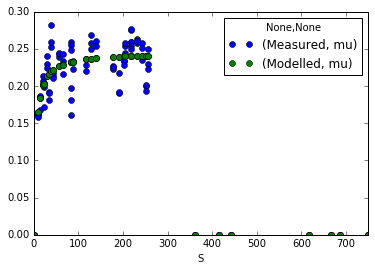

In [20]:
AA_Mon_ToxLim_optim.modmeas.plot(style='o')

## Butyric Acid

### Definition of models

In [21]:
#Define kinetic BA-models for model selection
Syst_BA_ToxLim= {'mu': ('mu_max*(1-1/(1+exp(-(S-Ki))))*(AA/(K_AA + AA))*(1-1/(1+exp(-(AA-Ki_AA))))')} #Proposed in this study
Syst_BA_LinInh= {'mu': ('mu_max*(1-K*S)*(1-1/(1+exp(-(S-1/K))))*(AA/(K_AA + AA))*(1-1/(1+exp(-(AA-Ki_AA))))')} # Hinshelwood (1952)

#Define initial parameter estimations for calibration of model selections
parameters_BA_ToxLim = {'mu_max': max(Data_All.mu),
                       'Ki':150., # Estimated based on available data
                         'K_AA':4.7, #Affinity index for AA obtained from model selection performed above
                        'Ki_AA':330.}
parameters_BA_LinInh = {'mu_max': max(Data_All.mu),
                       'K':1/150,
                         'K_AA':4.7,
                        'Ki_AA':330.}

### Toxicity limit

In [22]:
BA_ToxLim = AlgebraicModel('3D', Syst_BA_ToxLim, parameters_BA_ToxLim, ['S','AA'])
BA_ToxLim_data = Measurements(Data_BA)
BA_ToxLim_data.add_measured_errors({'mu': 0.04}, method='absolute')
BA_ToxLim_optim = ParameterOptimisation(BA_ToxLim, BA_ToxLim_data,
                                optim_par=['mu_max', 'Ki'])

In [23]:
BA_ToxLim_optim.local_optimize(method='Nelder-Mead',
                       options={'xatol': 1e-10, 'fatol': 1e-10})

 final_simplex: (array([[   0.25682215,  124.88079719],
       [   0.25682193,  124.88074838],
       [   0.25682235,  124.88072862]]), array([ 39.80682764,  39.80682764,  39.80682764]))
           fun: 39.806827641457403
       message: 'Optimization terminated successfully.'
          nfev: 100
           nit: 53
        status: 0
       success: True
             x: array([   0.25682215,  124.88079719])

In [24]:
BA_ToxLim.parameters

OrderedDict([('K_AA', 4.7),
             ('Ki', 124.88079719013604),
             ('Ki_AA', 330.0),
             ('mu_max', 0.25682214640366297)])

In [25]:
BA_ToxLim_conf = CalibratedConfidence(BA_ToxLim_optim)
BA_ToxLim_conf.get_parameter_confidence()

,value,lower,upper,delta,percent,t_value,t_reference,significant
mu_max,0.256822,0.229407,0.284237,0.027415,10.674806,18.773594,2.004045,1.0
Ki,124.880797,119.165176,130.596418,5.715621,4.576861,43.786443,2.004045,1.0


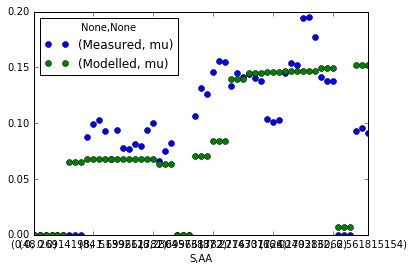

In [26]:
BA_ToxLim_optim.modmeas.plot(style='o')

### Linear Inhibition

In [27]:
BA_LinInh = AlgebraicModel('3D', Syst_BA_LinInh, parameters_BA_LinInh, ['S','AA'])
BA_LinInh_data = Measurements(Data_BA)
BA_LinInh_data.add_measured_errors({'mu': 0.04}, method='absolute')
BA_LinInh_optim = ParameterOptimisation(BA_LinInh, BA_LinInh_data,
                                optim_par=['mu_max', 'K'])

In [28]:
BA_LinInh_optim.local_optimize(method='Nelder-Mead',
                       options={'xatol': 1e-10, 'fatol': 1e-10})

 final_simplex: (array([[ 0.3535274 ,  0.0054089 ],
       [ 0.35360599,  0.00541231],
       [ 0.35343183,  0.00541024]]), array([ 42.21308524,  42.21309008,  42.21310858]))
           fun: 42.21308524312284
       message: 'Optimization terminated successfully.'
          nfev: 67
           nit: 36
        status: 0
       success: True
             x: array([ 0.3535274,  0.0054089])

Using a toxicity limit term, a residuals value of 39.8 was obtained, while with a linear inhibition term, this was 42.2. Based on this, the toxicity limit term was selected for further kinetic models.

In [29]:
BA_LinInh.parameters

OrderedDict([('K', 0.0054123128419742081),
             ('K_AA', 4.7),
             ('Ki_AA', 330.0),
             ('mu_max', 0.35360599272952487)])

In [30]:
BA_LinInh_conf = CalibratedConfidence(BA_LinInh_optim)
BA_LinInh_conf.get_parameter_confidence()

,value,lower,upper,delta,percent,t_value,t_reference,significant
mu_max,0.353606,0.306357,0.400855,0.047249,13.362026,14.998060,2.004045,1.0
K,0.005412,0.004291,0.006534,0.001121,20.717737,9.673087,2.004045,1.0


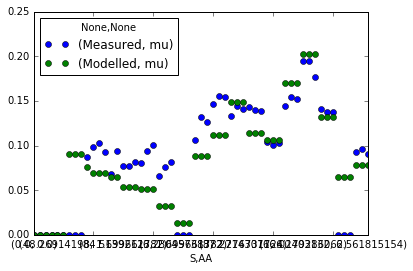

In [31]:
BA_LinInh_optim.modmeas.plot(style='o')

## Hexanoic Acid

### Definition of models

In [32]:
Syst_HA_ToxLim= {'mu': ('mu_max*(1-1/(1+exp(-(S-Ki))))')} # This study
Syst_HA_LinInh= {'mu': ('mu_max*(1-K*S)*(1-1/(1+exp(-(S-1/K))))')} # Hinshelwood (1952)

parameters_HA_ToxLim = {'mu_max': max(Data_All.mu),
                       'Ki':90.}
parameters_HA_LinInh = {'mu_max': max(Data_All.mu),
                       'K':1/90}

### Threshold Inhibition

In [33]:
HA_ToxLim = AlgebraicModel('3D', Syst_HA_ToxLim, parameters_HA_ToxLim, ['S'])
HA_ToxLim_data = Measurements(Data_HA)
HA_ToxLim_data.add_measured_errors({'mu': 0.04}, method='absolute')
HA_ToxLim_optim = ParameterOptimisation(HA_ToxLim, HA_ToxLim_data,
                                optim_par=['mu_max', 'Ki'])

In [34]:
HA_ToxLim_optim.local_optimize(method='Nelder-Mead',
                       options={'xatol': 1e-10, 'fatol': 1e-10})

 final_simplex: (array([[  0.14028032,  61.57025658],
       [  0.14028073,  61.570347  ],
       [  0.14028173,  61.57027783]]), array([ 11.02439152,  11.02439153,  11.02439154]))
           fun: 11.024391524075089
       message: 'Optimization terminated successfully.'
          nfev: 86
           nit: 45
        status: 0
       success: True
             x: array([  0.14028032,  61.57025658])

In [35]:
HA_ToxLim.parameters

OrderedDict([('Ki', 61.570347001531964), ('mu_max', 0.14028072731830424)])

In [36]:
HA_ToxLim_conf = CalibratedConfidence(HA_ToxLim_optim)
HA_ToxLim_conf.get_parameter_confidence()

,value,lower,upper,delta,percent,t_value,t_reference,significant
mu_max,0.140281,0.119525,0.161036,0.020756,14.795712,13.582146,2.009575,1.0
Ki,61.570347,60.158044,62.982650,1.412303,2.293803,87.608881,2.009575,1.0


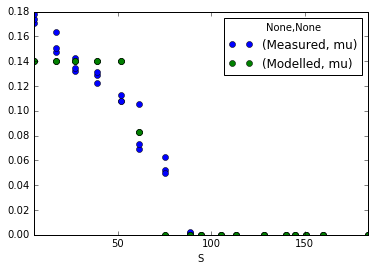

In [37]:
HA_ToxLim_optim.modmeas.plot(style='o')

### Linear Inhibition

In [38]:
HA_LinInh = AlgebraicModel('3D', Syst_HA_LinInh, parameters_HA_LinInh, ['S'])
HA_LinInh_data = Measurements(Data_HA)
HA_LinInh_data.add_measured_errors({'mu': 0.04}, method='absolute')
HA_LinInh_optim = ParameterOptimisation(HA_LinInh, HA_LinInh_data,
                                optim_par=['mu_max', 'K'])

In [39]:
HA_LinInh_optim.local_optimize(method='Nelder-Mead',
                       options={'xatol': 1e-10, 'fatol': 1e-10})

 final_simplex: (array([[ 0.19393201,  0.0101802 ],
       [ 0.1938734 ,  0.01018343],
       [ 0.19395092,  0.01018651]]), array([ 2.83443259,  2.83446633,  2.83450646]))
           fun: 2.8344325854328365
       message: 'Optimization terminated successfully.'
          nfev: 78
           nit: 40
        status: 0
       success: True
             x: array([ 0.19393201,  0.0101802 ])

Comparing the residuals value of 2.8 obtained with the linear inhibition model to the 11.0 obtained by a toxicity limit model - as well as the visually better fit - gives a clear preference to the linear inhibition model as the better model.

In [40]:
HA_LinInh.parameters

OrderedDict([('K', 0.010183427679732768), ('mu_max', 0.19387340107174139)])

In [41]:
HA_LinInh_conf = CalibratedConfidence(HA_LinInh_optim)
HA_LinInh_conf.get_parameter_confidence()

,value,lower,upper,delta,percent,t_value,t_reference,significant
mu_max,0.193873,0.163399,0.224348,0.030475,15.718905,12.784448,2.009575,1.0
K,0.010183,0.008698,0.011669,0.001485,14.586149,13.777285,2.009575,1.0


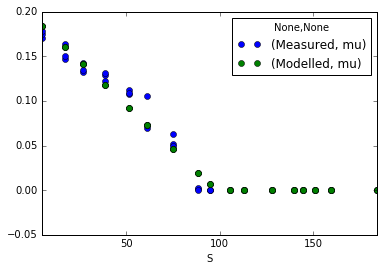

In [42]:
HA_LinInh_optim.modmeas.plot(style='o')

# Overall model

## Definition of overall model

In [43]:
Syst_Total = {'mu': ('mu_max*(AA/(Ks_AA + AA))*(1-1/(1+exp(-(AA-Ki_AA))))*'
                     '(1-1/(1+exp(-(BA-Ki_BA))))*'
                     '(1-K_HA*HA)*(1-1/(1+exp(-(HA-1/K_HA))))')} #Multiplication of all terms selected above.

#Initial parameter estimates come from values obtained in model selection calibration
parameters_Total = {'mu_max': max(AA_Mon_ToxLim.parameters['mu_max'],BA_ToxLim.parameters['mu_max'],HA_LinInh.parameters['mu_max']),
                    'Ks_AA': AA_Mon_ToxLim.parameters['K_S'],    
                    'Ki_AA':AA_Mon_ToxLim.parameters['Ki'],
                    'Ki_BA':BA_ToxLim.parameters['Ki'],
                    'K_HA':HA_LinInh.parameters['K']} 

In [44]:
parameters_Total

{'K_HA': 0.010183427679732768,
 'Ki_AA': 330.0,
 'Ki_BA': 124.88079719013604,
 'Ks_AA': 4.6911058864579669,
 'mu_max': 0.25682214640366297}

## Calibration

In [45]:
Total = AlgebraicModel('3D', Syst_Total, parameters_Total, ['AA','BA','HA'])
Total_data = Measurements(Data_All)
Total_data.add_measured_errors({'mu': 0.04}, method='absolute')
Total_optim = ParameterOptimisation(Total, Total_data,
                                optim_par=['mu_max','Ks_AA', 'Ki_BA','K_HA'])

In [46]:
Total_optim.local_optimize(method='Nelder-Mead',
                       options={'xatol': 1e-10, 'fatol': 1e-10})

 final_simplex: (array([[  2.40086102e-01,   3.81233683e+00,   1.24705158e+02,
          1.09492835e-02],
       [  2.40085991e-01,   3.81232182e+00,   1.24705120e+02,
          1.09492651e-02],
       [  2.40085998e-01,   3.81233118e+00,   1.24705155e+02,
          1.09492984e-02],
       [  2.40085986e-01,   3.81231970e+00,   1.24705248e+02,
          1.09492741e-02],
       [  2.40086047e-01,   3.81231790e+00,   1.24705209e+02,
          1.09492765e-02]]), array([ 73.59101938,  73.59101938,  73.59101938,  73.59101938,  73.59101938]))
           fun: 73.591019378089257
       message: 'Optimization terminated successfully.'
          nfev: 224
           nit: 127
        status: 0
       success: True
             x: array([  2.40086102e-01,   3.81233683e+00,   1.24705158e+02,
         1.09492835e-02])

In [47]:
Total.parameters

OrderedDict([('K_HA', 0.010949265147387499),
             ('Ki_AA', 330.0),
             ('Ki_BA', 124.70512041691399),
             ('Ks_AA', 3.8123218227739994),
             ('mu_max', 0.24008599087731275)])

In [48]:
Total_conf = CalibratedConfidence(Total_optim)

In [49]:
Total_conf.get_parameter_confidence()

,value,lower,upper,delta,percent,t_value,t_reference,significant
mu_max,0.240086,0.229471,0.250701,0.010615,4.421298,44.592036,1.971547,1.0
Ks_AA,3.812322,2.865528,4.759116,0.946794,24.835108,7.938547,1.971547,1.0
Ki_BA,124.705120,119.027592,130.382649,5.677529,4.552763,43.304398,1.971547,1.0
K_HA,0.010949,0.009653,0.012245,0.001296,11.834977,16.658644,1.971547,1.0


In [50]:
Total_conf.get_parameter_correlation()

,mu_max,Ks_AA,Ki_BA,K_HA
mu_max,1.000000,0.578691,0.056992,0.161880
Ks_AA,0.578691,1.000000,0.155685,0.056041
Ki_BA,0.056992,0.155685,1.000000,0.002282
K_HA,0.161880,0.056041,0.002282,1.000000


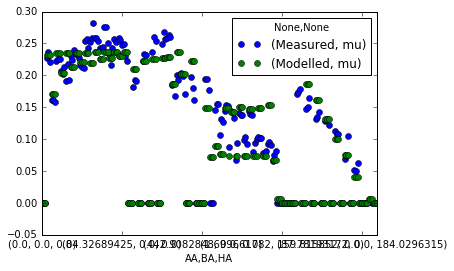

In [51]:
Total_optim.modmeas.plot(style='o')

# Dynamic mass-balance model

## Model definition

In [52]:
Dynamic_System = {'dSEtOH': '(-(W1*mu_1/Y_EtOH) - (W2*mu_2/Y_EtOH))*X',
          'dSAA': '(-2/3*(W1*mu_1/Y_EtOH)+1/6*(W2*mu_2/Y_EtOH))*X', 
          'dSBA': '(5/6*(W1*mu_1/Y_EtOH) - 5/6*(W2*mu_2/Y_EtOH))*X', 
          'dSHA': '5/6*(W2*mu_2/Y_EtOH)*X', 
          'dH2': '(2/6*(W1*mu_1/Y_EtOH) + 2/6*(W2*mu_2/Y_EtOH))*X', 
          'dH': '(1/6*(W1*mu_1/Y_EtOH) + 1/6*(W2*mu_2/Y_EtOH))*X', 
          'dX': 'mu*X',
          'mu': 'W1*mu_1+W2*mu_2-b',
          'W1':'(mu_1)/(mu_1+mu_2)',
          'W2':'(mu_2)/(mu_1+mu_2)',          
          'mu_1': 'mu_max*(SAA/(Ks_AA + SAA))*(1-1/(1+exp(-(SAA-Ki_AA))))'
                  '*(1-1/(1+exp(-(SBA-Ki_BA))))'
                  '*(1-K_HA*SHA)*(1-1/(1+exp(-(SHA-1/K_HA))))'
                  '*(SEtOH/(Ks_EtOH + SEtOH))',
          'mu_2': 'mu_max*(1-1/(1+exp(-(SBA-Ki_BA))))*(SBA/(Ks_BA + SBA))'
                  '*(1-K_HA*SHA)*(1-1/(1+exp(-(SHA-1/K_HA))))'
                  '*(1-1/(1+exp(-(SAA-Ki_AA))))'
                  '*(SEtOH/(Ks_EtOH + SEtOH))',
                 }
     
Dynamic_Par = {'Ks_AA': Total.parameters['Ks_AA'], #[mM]
              'Ks_BA': 3.5, #[mM] -> Cavalcante et al. (2017)
              'Ks_EtOH': 11.8, #[mM] Cavalcante et al. (2017)
              'K_HA': Total.parameters['K_HA'], #[mM] -> From parameter estimation
              'Ki_AA': Total.parameters['Ki_AA'], #[mM] -> From parameter estimation
              'Ki_BA': Total.parameters['Ki_AA'], #[mM] -> From parameter estimation
              'mu_max': Total.parameters['mu_max'], #[h^-1] -> From parameter estimation
              'b': 0., #[h^-1] -> Can be added to the model, but parameter was neglected for this study
              'Y_EtOH':2.75/1000, #[g Cells/mmol EtOH]
             }

## Run mass-balance model

In [53]:
Dynamic_Init = {'SEtOH': 330, #[mM] #DSM52 composition
           'SAA': 110, #[mM]
           'SBA': 0, #[mM]
           'SHA': 0, #[mM]
           'H2': 0., #[mM]
           'H': 1e-7, #[M]
           'X': 0.13} #[g cells/L]

# Declaration of independent variable
time=np.linspace(0, 70, 50000)
independent = {'t': time}

# Run simulation
Dynamic = Model('Dynamic Simulation', Dynamic_System, Dynamic_Par)
Dynamic.parameters
Dynamic.initial_conditions = Dynamic_Init
Dynamic.independent = independent
Dynamic.initialize_model()
Dynamic_Out = Dynamic.run()

In [54]:
#Process ouput

X=Dynamic_Out['X']

SEtOH=Dynamic_Out['SEtOH']
SEtOH=pd.Series(SEtOH,index=time)

SAA=Dynamic_Out['SAA']
SAA=pd.Series(SAA,index=time)

SBA=Dynamic_Out['SBA']
SBA=pd.Series(SBA,index=time)

SHA=Dynamic_Out['SHA']
SHA=pd.Series(SHA,index=time)

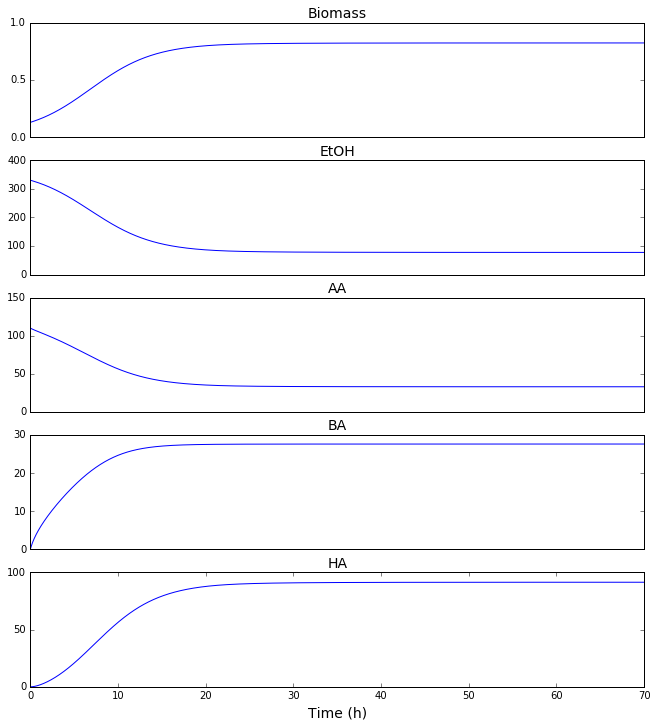

In [55]:
Fig = plt.figure(figsize=((11,7*1.7)))

#Plot experiment data
a_X = plt.subplot(5,1,1)
a_X.set_title("Biomass",fontsize=14)
a_X.plot(X)
a_X.xaxis.set_visible(False)
a_X.locator_params(axis='y',nbins=3)

a_EtOH = plt.subplot(5,1,2)
a_EtOH.set_title("EtOH",fontsize=14)
a_EtOH.plot(SEtOH)
a_EtOH.xaxis.set_visible(False)
a_EtOH.locator_params(axis='y',nbins=4)
    
a_AA = plt.subplot(5,1,3)
a_AA.set_title("AA",fontsize=14)
a_AA.plot(SAA)
a_AA.xaxis.set_visible(False)
a_AA.locator_params(axis='y',nbins=3)
    
a_BA = plt.subplot(5,1,4)
a_BA.set_title("BA",fontsize=14)
a_BA.plot(SBA)
a_BA.xaxis.set_visible(False)
a_BA.locator_params(axis='y',nbins=3)
    
a_HA=plt.subplot(5,1,5)
a_HA.set_title("HA",fontsize=14)
a_HA.plot(SHA)
a_HA.locator_params(axis='y',nbins=3)

plt.xlabel('Time (h)', fontsize = 14)
plt.savefig('DynamicOutput.png',bbox_inches='tight')

# Continuous Model

## Model definition

In [56]:
Continuous_System = {'dSEtOH': '(-(W1*mu_1/Y_EtOH) - (W2*mu_2/Y_EtOH))*X+D*(SEtOH_in-SEtOH)',
          'dSAA': '(-2/3*(W1*mu_1/Y_EtOH)+1/6*(W2*mu_2/Y_EtOH))*X+D*(SAA_in-SAA)', 
          'dSBA': '(5/6*(W1*mu_1/Y_EtOH) - 5/6*(W2*mu_2/Y_EtOH))*X+D*(SBA_in-SBA)', 
          'dSHA': '5/6*(W2*mu_2/Y_EtOH)*X+D*(SHA_in-SHA)', 
          'dH2': '(2/6*(W1*mu_1/Y_EtOH) + 2/6*(W2*mu_2/Y_EtOH))*X', 
          'dH': '(1/6*(W1*mu_1/Y_EtOH) + 1/6*(W2*mu_2/Y_EtOH))*X', 
          'dX': '(mu-D)*X',
          'mu': 'W1*mu_1+W2*mu_2-b',
          'W1':'(mu_1)/(mu_1+mu_2)',
          'W2':'(mu_2)/(mu_1+mu_2)',          
          'mu_1': 'mu_max*(SAA/(Ks_AA + SAA))*(1-1/(1+exp(-(SAA-Ki_AA))))'
                  '*(1-1/(1+exp(-(SBA-Ki_BA))))'
                  '*(1-K_HA*SHA)*(1-1/(1+exp(-(SHA-1/K_HA))))'
                  '*(SEtOH/(Ks_EtOH + SEtOH))',
          'mu_2': 'mu_max*(1-1/(1+exp(-(SBA-Ki_BA))))*(SBA/(Ks_BA + SBA))'
                  '*(1-K_HA*SHA)*(1-1/(1+exp(-(SHA-1/K_HA))))'
                  '*(1-1/(1+exp(-(SAA-Ki_AA))))'
                  '*(SEtOH/(Ks_EtOH + SEtOH))',
                 }
     
Continuous_Par = {'Ks_AA': Total.parameters['Ks_AA'], #[mM]
              'Ks_BA': 3.5, #[mM] -> Cavalcante et al. (2017)
              'Ks_EtOH': 11.8, #[mM] Cavalcante et al. (2017)
              'K_HA': Total.parameters['K_HA'], #[mM] -> From parameter estimation
              'Ki_AA': Total.parameters['Ki_AA'], #[mM] -> From parameter estimation
              'Ki_BA': Total.parameters['Ki_AA'], #[mM] -> From parameter estimation
              'mu_max': Total.parameters['mu_max'], #[h^-1] -> From parameter estimation
              'b': 0., #[h^-1] -> Can be added to the model, but parameter was neglected for this study
              'Y_EtOH':2.75/1000, #[g Cells/mmol EtOH]
              # Parameters for chemostat operation - influent concentrations and dilution rate
              'SEtOH_in':330,
              'SAA_in':100,
              'SBA_in':0.,
              'SHA_in':0.,
              'D':0.05,
             }



In [57]:
Continuous_Init = {'SEtOH': Continuous_Par['SEtOH_in'], #[mM]
           'SAA': Continuous_Par['SAA_in'], #[mM]
           'SBA': Continuous_Par['SBA_in'], #[mM]
           'SHA': Continuous_Par['SHA_in'], #[mM]
           'H2': 0., #[mM]
           'H': 1e-7, #[M]
           'X':  0.13} #[g cells/L]

#Declaration of independent variable
time=np.linspace(0, 500, 5000000)
independent = {'t': time}

Continuous = Model('Continuous Simulation', Continuous_System, Continuous_Par)
Continuous.parameters
Continuous.initial_conditions = Continuous_Init
Continuous.independent = independent
Continuous.initialize_model()
Continuous_Out = Continuous.run()

In [58]:
X_Cont=Continuous_Out['X']

SEtOH_Cont=Continuous_Out['SEtOH']
SEtOH_Cont=pd.Series(SEtOH_Cont,index=time)

SAA_Cont=Continuous_Out['SAA']
SAA_Cont=pd.Series(SAA_Cont,index=time)

SBA_Cont=Continuous_Out['SBA']
SBA_Cont=pd.Series(SBA_Cont,index=time)

SHA_Cont=Continuous_Out['SHA']
SHA_Cont=pd.Series(SHA_Cont,index=time)

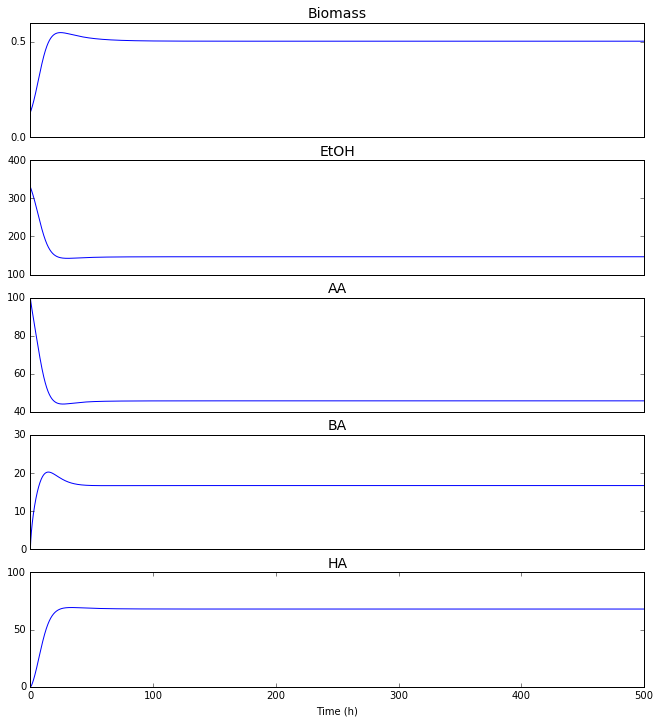

In [59]:
Fig_Cont = plt.figure(figsize=((11,7*1.7)))

#Plot experiment data
a_X = plt.subplot(5,1,1)
a_X.set_title("Biomass",fontsize=14)
a_X.plot(X_Cont)
a_X.xaxis.set_visible(False)
a_X.locator_params(axis='y',nbins=3)

a_EtOH = plt.subplot(5,1,2)
a_EtOH.set_title("EtOH",fontsize=14)
a_EtOH.plot(SEtOH_Cont)
a_EtOH.xaxis.set_visible(False)
a_EtOH.locator_params(axis='y',nbins=4)
    
a_AA = plt.subplot(5,1,3)
a_AA.set_title("AA",fontsize=14)
a_AA.plot(SAA_Cont)
a_AA.xaxis.set_visible(False)
a_AA.locator_params(axis='y',nbins=3)
    
a_BA = plt.subplot(5,1,4)
a_BA.set_title("BA",fontsize=14)
a_BA.plot(SBA_Cont)
a_BA.xaxis.set_visible(False)
a_BA.locator_params(axis='y',nbins=3)
    
a_HA=plt.subplot(5,1,5)
a_HA.set_title("HA",fontsize=14)
a_HA.plot(SHA_Cont)
a_HA.locator_params(axis='y',nbins=3)

plt.xlabel('Time (h)')

# Bibliography

Cavalcante WDA, Leitão RC, Gehring TA, Angenent LT, Santaella ST. 2017. Anaerobic fermentation for n-caproic acid production: A review. Process Biochem. 54:106–119

Daele T, Van Hoey S, Nopens I. 2015. pyIDEAS: an Open Source Python Package for 514 Model Analysis. In: . Comput Aided Chem Eng, Vol. 37, pp. 569–574.

Hinshelwood CN. 1952. The Chemical Kinetics Of The Bacterial Cell. Clarendon, Oxford.

Monod J. 1949. The Growth Of Bacterial Cultures. Annu. Rev. Microbiol. 3:371–394.

Sivakumar A, Srinivasaraghavan T, Swaminathan T, Baradarajan A. 1994. Extended monod kinetics for substrate inhibited systems. Bioprocess Eng. 11:185–188.